Прогнозирование акций компании Лукойл.

In [ ]:
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, LSTM, Flatten, Conv1D, MaxPooling1D, RepeatVector # Cтандартные слои
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, Callback
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Загрузка

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/18_19.csv', sep=';')
data.head(3)

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722


In [ ]:
# Глобальные переменные
xLen = 100                    # Анализируем по 100 прошедшим точкам
valLen = 9000                 # Используем valLen записей для проверки
nrate=1                       # множитель  sampling_rate, stride

data.index = pd.to_datetime(data.DATE)
data = data[(data.index>'2018-12-31')]
data = data.iloc[:,2:] 
dn = np.array(data)
dn.shape

(84918, 5)

Смотрим вид ряда, к-й будем предсказывать

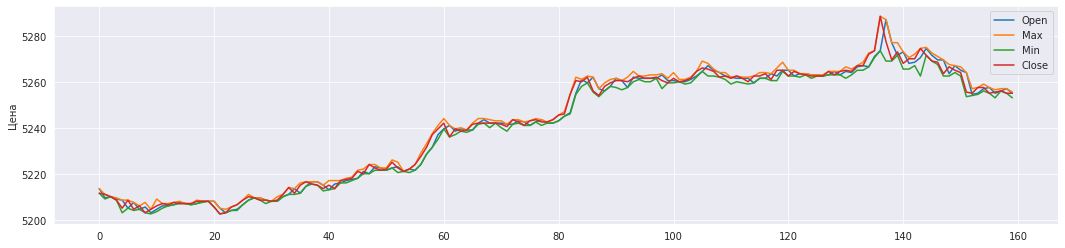

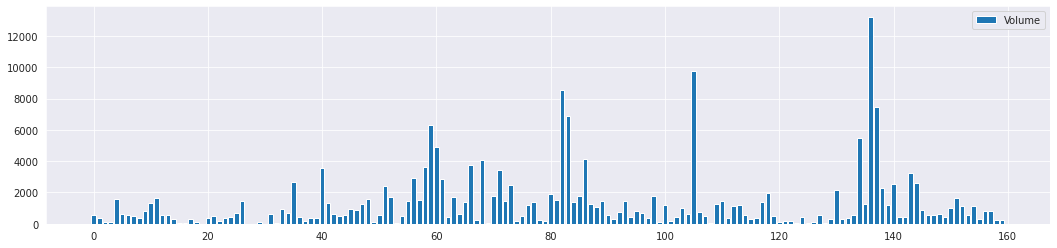

In [ ]:
start =dn.shape[0] - valLen + 2*xLen +2
length = 160
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']
plt.figure(figsize=(18,4))
for i in range(4):            # Рисуем 4 канала
  plt.plot(dn[start:start+length,i], label = chanelNames[i])
plt.ylabel('Цена')
plt.legend()
plt.show()

# Volume
plt.figure(figsize=(18,4))
plt.bar(np.arange(length), height=dn[start:start+length,4], label='Volume')
plt.legend()
plt.show()

Визуализация результатов

In [ ]:
def getPred(currModel, xVal, yVal, yScaler):                    # Предсказание на тестовой выборке
  predVal = yScaler.inverse_transform(currModel.predict(xVal))   
  yValUnscaled = yScaler.inverse_transform(yVal)

  return (predVal, yValUnscaled)

def correlate(a, b):        # Корреляция
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()

  val = 1
  if ((sa > 0) & (sb > 0)):
    val = (mab - ma*mb)/(sa*sb)
  return val

def showPredict(start,step,channel, predVal, yValUnscaled):     # Визуализация

  plt.figure(1, figsize=(20,4))
  plt.subplot(121) #  1 - кол-во строк, 2 - кол-во столбцов, 1 - какой по счету  график
  plt.plot(predVal[start:start+step,0], label = 'Прогноз')
  plt.plot(yValUnscaled[start:start+step,channel], label = 'Базовый ряд')
  plt.xlabel("Время")
  plt.ylabel("Close")
  plt.legend()

  corr = []
  ch=0
  yLen = yValUnscaled.shape[0]
  for i in range(10):
    corr.append(correlate(yValUnscaled[:yLen-i,ch],predVal[i:,0]))

  own_corr = []
  for i in range(10):
    own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:,ch]))

  plt.subplot(122) 
  plt.plot(corr, label='Прогноз')
  plt.plot(own_corr, label='Эталон')
  plt.xlabel('шаг')
  plt.legend()
  plt.show()  

Функции подготовки датасета 
_______________________________________________________________________
1. попарные разности каналов
2. модули попарных разностей каналов
3. попарные произведения каналов
4. обратное значение каналов x_new = 1/(x + 1e-3)
5. первые производные каналов (x[n] - x[n-1])
6. вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])
______________________________________________________________________
1. 100 точек с шагом назад по 1 
2. 100 точек с шагом назад по 10
3. 100 точек с шагом назад - среднее по отрезку в 10 точек 

In [ ]:
def datamean10(data) :    # Возвращает  средние по 10-ти точкам
    df = data.copy()
    for i in range(df.shape[1]):        
      col = df[df.columns[i]]       
      lc =[]
      for j in range(len(col)//10):     
        lc.append(sum(col[j*10:j*10+10])/10)   # Среднее по 10-ти
      an = np.array(lc) 
      if i==0:
        dn = an.reshape(-1,1)
      else:
        dn = np.hstack([dn, an.reshape(-1,1)])
    return pd.DataFrame(dn)   #  <= Среднее по 10-ти точкам

In [ ]:
def prepareDataSet(dfb, ex):          # Возвращает Dataset в np.array с новыми столбцами
  cn = 'qwertyuiopasdfghjklzxcvbnm'   # имена новых столбцов df 
  df =dfb.copy()                      # df - изменяеый Dataset
  if ex == 0:
    print('1. - Попарные разности каналов',end = ': ')
    for i in range(4):                       # попарные разности каналов
      for j in range(i+1,4):
        df[cn[i*2+j]] = df[df.columns[i]] - df[df.columns[j]] 
        print (i,j,end = ', ')
    dn = np.array(df)     

  if ex == 1:
    print('\n2. - Модули попарных разностей каналов',end = ': ')
    for i in range(4):                      # модули попарных разностей каналов
      for j in range(i+1,4):
        df[cn[i*2+j]] = abs(df[df.columns[i]] - df[df.columns[j]] )
        print (i,j,end = ', ')
    dn = np.array(df)       

  if ex == 2:
    print('\n3. - Попарные произведения каналов',end = ': ')
    for i in range(4):                       # попарные произведения каналов
      for j in range(i+1,5):
        df[cn[i*3+j]] = df[df.columns[i]] * df[df.columns[j]]
        print (i,j,end = ', ')
    dn = np.array(df)           

  if ex == 3:
    print('\n4. - Обратные величины  1/(x+1e-3)',end = ': ') 
    for i in range(5):                       #x_new = 1/(x + 1e-3)
        df[cn[i]] = 1/(df[df.columns[i]] +1e-3)
    dn = np.array(df)    

  if ex == 4:
    print('\n5. - Первые производные каналов',end = ': ')
    ddf = df.diff()         # первые производные каналов (x[n] - x[n-1])     
    dn = np.array(df[1:]) 
    ddn = np.array(ddf[1:]) 
    dn = np.hstack([dn,ddn])

  if ex == 5:
    print('\n6. - Вторые производные каналов',end = ': ')
    ddf = df.diff()      # первые производные каналов (x[n] - x[n-1])
    d2f = ddf.diff()      # вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])
    dn = np.array(df[2:]) 
    ddn = np.array(d2f[2:]) 
    dn = np.hstack([dn,ddn])

  return dn

Тестируем  функции подготовки датасета 

In [ ]:
ats = np.arange(1,121)
ats = ats.reshape(-1,4)
dtst = pd.DataFrame(ats)        # Dataset для проверки функций
ltst = [1,2,4,3,5,5,6,7,8,9,11,2,4,3,5,5,6,7,8,9,21,22,4,3,5,5,6,7,8,9]
dtst['4'] = ltst
dtst.head(3)    # 4 =>  2-Й дифференциал > 0;   для проверки ф-и 2-й произв.

,0,1,2,3,4
0,1,2,3,4,1
1,5,6,7,8,2
2,9,10,11,12,4


In [ ]:
data10 = datamean10(dtst) #  <= Среднее по 10-ти точкам
data10                      # 4 =>  2-Й дифференциал > 0;   для проверки ф-и 2-й произв.

,0,1,2,3,4
0,19.0,20.0,21.0,22.0,5.0
1,59.0,60.0,61.0,62.0,6.0
2,99.0,100.0,101.0,102.0,9.0


Тест подготовки датасета в цикле

In [ ]:
data10 = datamean10(dtst)
for exp_step in ('I','II','III'):       # 3 варианта шага
  nrate=1                       # множитель sampling_rate, stride 
  valLen = 9000                 # начало тестовой
  dfb = dtst.copy()             # восстанавливаем исх. данные

  if exp_step == 'II':             
    nrate=10                    # через 10  точек

  msg = exp_step +'.\t100 точек с шагом назад по ' + str(nrate)
  if exp_step == 'III':
    dfb = data10.copy()           # cpeднeeе
    valLen //= 10
    msg += ', cреднее по 10-ти точкам' 

  print(msg)

  for experience in range(6):  # 6 вариантов данных.
    dn = prepareDataSet(dfb,experience)
    print('\tdn =',end=' ')    # Тестовая часть
    for u in dn[0]:
      print("{:n}".format(u),end=' ')

    if experience == 5 : 
      print('\n')   

I.	100 точек с шагом назад по 1
1. - Попарные разности каналов: 0 1, 0 2, 0 3, 1 2, 1 3, 2 3, 	dn = 1 2 3 4 1 -1 -2 -3 -1 -2 -1 
2. - Модули попарных разностей каналов: 0 1, 0 2, 0 3, 1 2, 1 3, 2 3, 	dn = 1 2 3 4 1 1 2 3 1 2 1 
3. - Попарные произведения каналов: 0 1, 0 2, 0 3, 0 4, 1 2, 1 3, 1 4, 2 3, 2 4, 3 4, 	dn = 1 2 3 4 1 2 3 4 1 6 8 2 12 3 4 
4. - Обратные величины  1/(x+1e-3): 	dn = 1 2 3 4 1 0.999001 0.49975 0.333222 0.249938 0.999001 
5. - Первые производные каналов: 	dn = 5 6 7 8 2 4 4 4 4 1 
6. - Вторые производные каналов: 	dn = 9 10 11 12 4 0 0 0 0 1 

II.	100 точек с шагом назад по 10
1. - Попарные разности каналов: 0 1, 0 2, 0 3, 1 2, 1 3, 2 3, 	dn = 1 2 3 4 1 -1 -2 -3 -1 -2 -1 
2. - Модули попарных разностей каналов: 0 1, 0 2, 0 3, 1 2, 1 3, 2 3, 	dn = 1 2 3 4 1 1 2 3 1 2 1 
3. - Попарные произведения каналов: 0 1, 0 2, 0 3, 0 4, 1 2, 1 3, 1 4, 2 3, 2 4, 3 4, 	dn = 1 2 3 4 1 2 3 4 1 6 8 2 12 3 4 
4. - Обратные величины  1/(x+1e-3): 	dn = 1 2 3 4 1 0.999001 0.49975 0.33

Тестируем генератор - шаг 10


In [ ]:
atsg = np.arange(1011)
x_train = y_train = atsg # Создаем x_train,y_train
nrate = 10   # множитель sampling_rate, stride 
gen = TimeseriesGenerator( x_train,  y_train,  length= 100 *nrate,
    sampling_rate=nrate,   stride=nrate,    batch_size=1 )
for i, g in enumerate(gen):
  print('Батч №', i, ' x_train  y_train')
  print(g[0],g[1])

Батч № 0  x_train  y_train
[[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
  180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
  360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
  540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
  720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
  900 910 920 930 940 950 960 970 980 990]] [1000]
Батч № 1  x_train  y_train
[[  10   20   30   40   50   60   70   80   90  100  110  120  130  140
   150  160  170  180  190  200  210  220  230  240  250  260  270  280
   290  300  310  320  330  340  350  360  370  380  390  400  410  420
   430  440  450  460  470  480  490  500  510  520  530  540  550  560
   570  580  590  600  610  620  630  640  650  660  670  680  690  700
   710  720  730  740  750  760  770  780  790  800  810  820  830  840
   850  860  870  880  890  900  910  920  930  940  950  960  970  980
   990 1000]] [1010]


Проведение опытов

1.   Формирование обучающей и тестовой выборки
2.   Обучение модели, визуализация



I.	100 точек с шагом назад по 1
1. - Попарные разности каналов: 0 1, 0 2, 0 3, 1 2, 1 3, 2 3, TrainTest.shape: (75918, 11) (75918, 1) (8898, 11) (8898, 1)


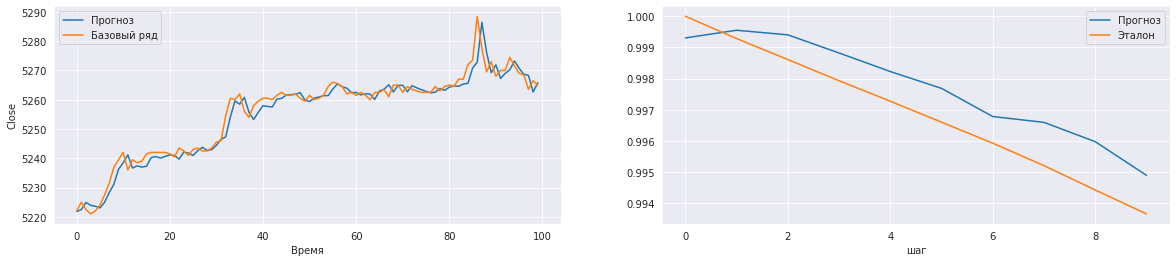


2. - Модули попарных разностей каналов: 0 1, 0 2, 0 3, 1 2, 1 3, 2 3, TrainTest.shape: (75918, 11) (75918, 1) (8898, 11) (8898, 1)


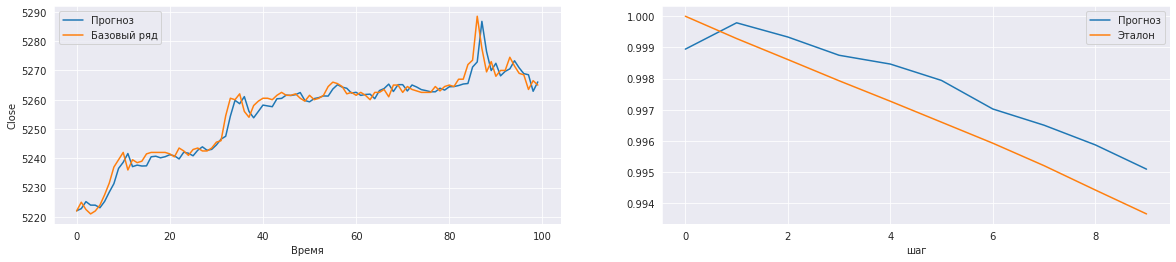


3. - Попарные произведения каналов: 0 1, 0 2, 0 3, 0 4, 1 2, 1 3, 1 4, 2 3, 2 4, 3 4, TrainTest.shape: (75918, 15) (75918, 1) (8898, 15) (8898, 1)


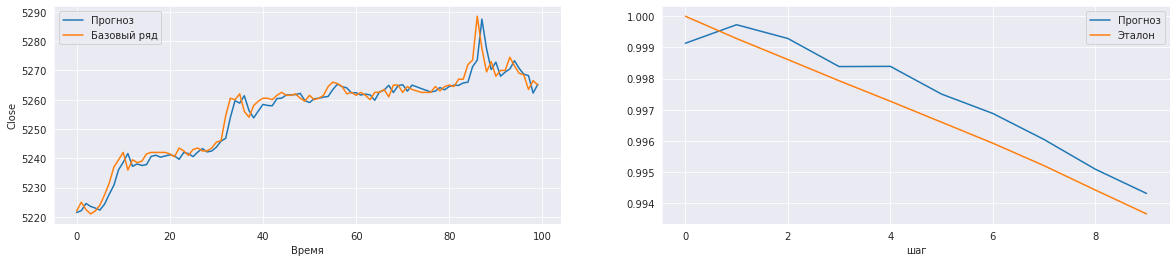


4. - Обратные величины  1/(x+1e-3): TrainTest.shape: (75918, 10) (75918, 1) (8898, 10) (8898, 1)


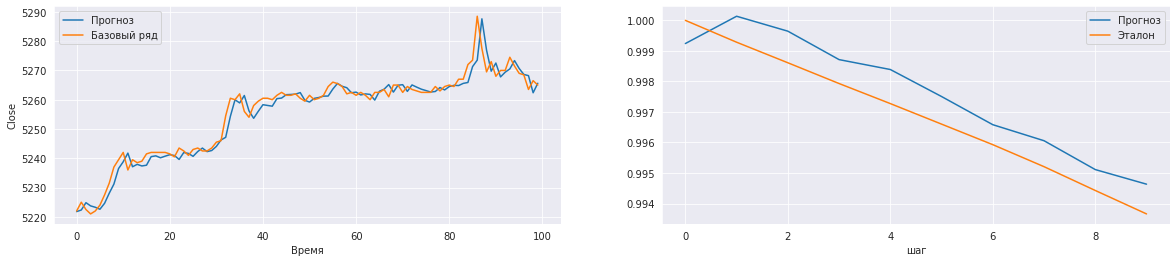


5. - Первые производные каналов: TrainTest.shape: (75917, 10) (75917, 1) (8898, 10) (8898, 1)


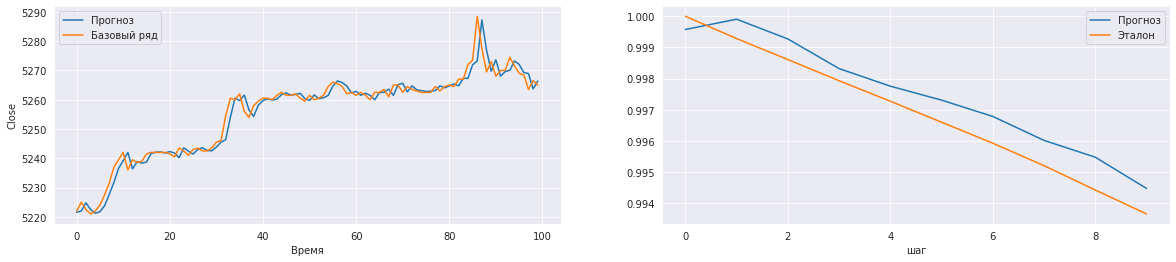


6. - Вторые производные каналов: TrainTest.shape: (75916, 10) (75916, 1) (8898, 10) (8898, 1)


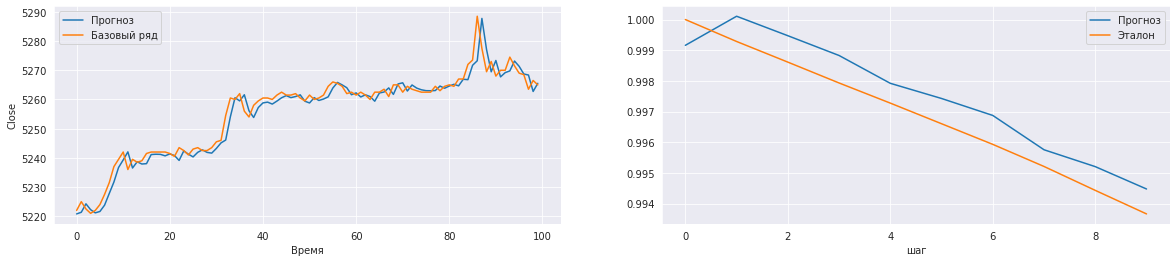

II.	100 точек с шагом назад по 10
1. - Попарные разности каналов: 0 1, 0 2, 0 3, 1 2, 1 3, 2 3, TrainTest.shape: (75918, 11) (75918, 1) (8898, 11) (8898, 1)


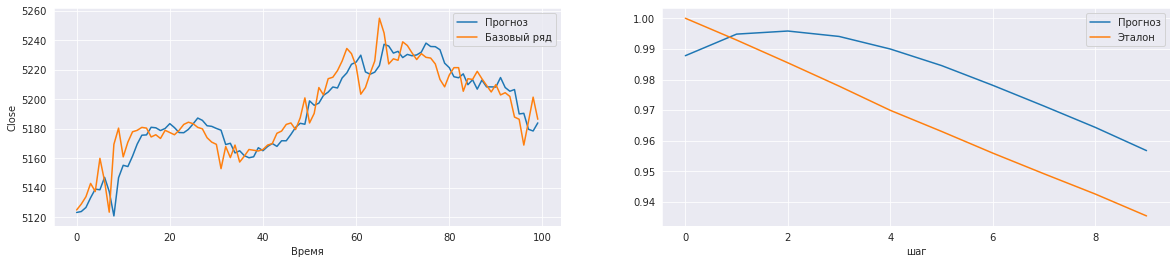


2. - Модули попарных разностей каналов: 0 1, 0 2, 0 3, 1 2, 1 3, 2 3, TrainTest.shape: (75918, 11) (75918, 1) (8898, 11) (8898, 1)


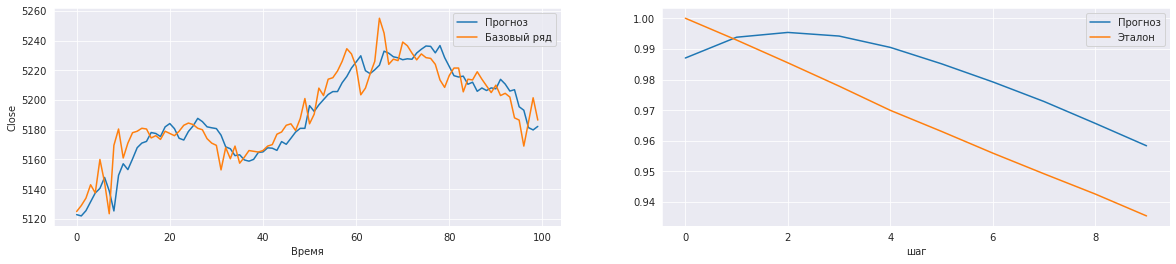


3. - Попарные произведения каналов: 0 1, 0 2, 0 3, 0 4, 1 2, 1 3, 1 4, 2 3, 2 4, 3 4, TrainTest.shape: (75918, 15) (75918, 1) (8898, 15) (8898, 1)


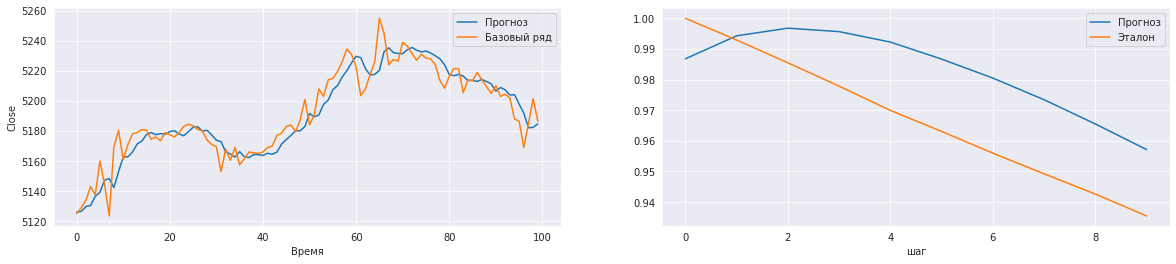


4. - Обратные величины  1/(x+1e-3): TrainTest.shape: (75918, 10) (75918, 1) (8898, 10) (8898, 1)


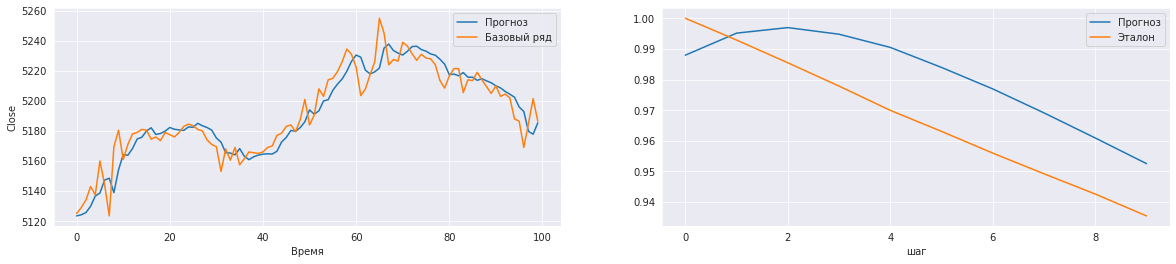


5. - Первые производные каналов: TrainTest.shape: (75917, 10) (75917, 1) (8898, 10) (8898, 1)


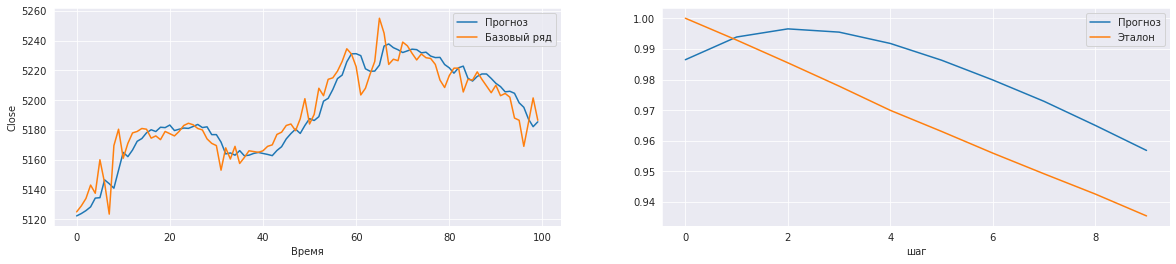


6. - Вторые производные каналов: TrainTest.shape: (75916, 10) (75916, 1) (8898, 10) (8898, 1)


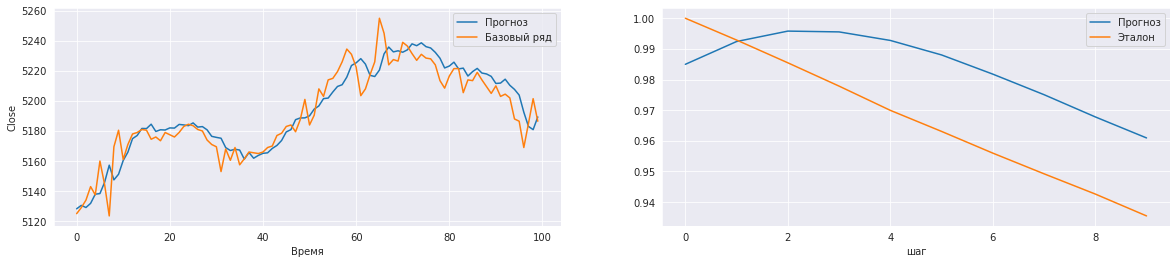

III.	100 точек с шагом назад по 1, cреднее по 10-ти точкам
1. - Попарные разности каналов: 0 1, 0 2, 0 3, 1 2, 1 3, 2 3, TrainTest.shape: (7591, 11) (7591, 1) (798, 11) (798, 1)


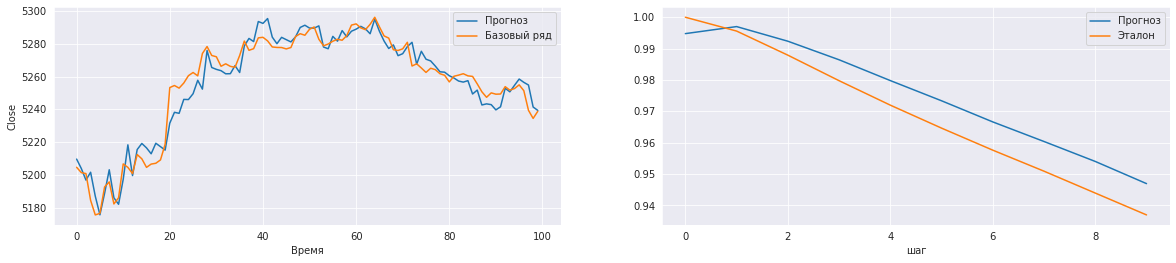


2. - Модули попарных разностей каналов: 0 1, 0 2, 0 3, 1 2, 1 3, 2 3, TrainTest.shape: (7591, 11) (7591, 1) (798, 11) (798, 1)


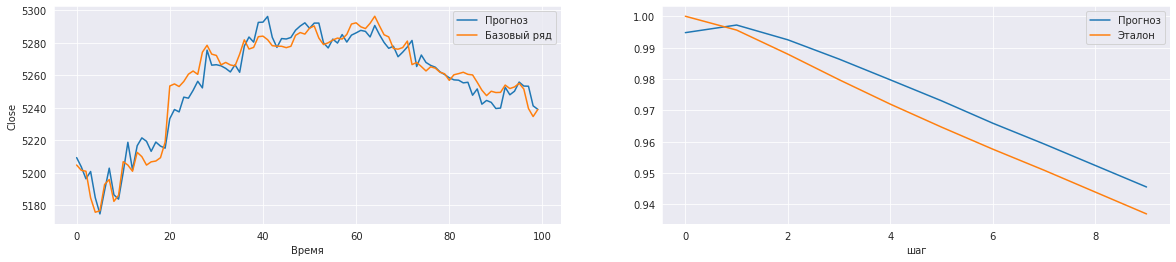


3. - Попарные произведения каналов: 0 1, 0 2, 0 3, 0 4, 1 2, 1 3, 1 4, 2 3, 2 4, 3 4, TrainTest.shape: (7591, 15) (7591, 1) (798, 15) (798, 1)


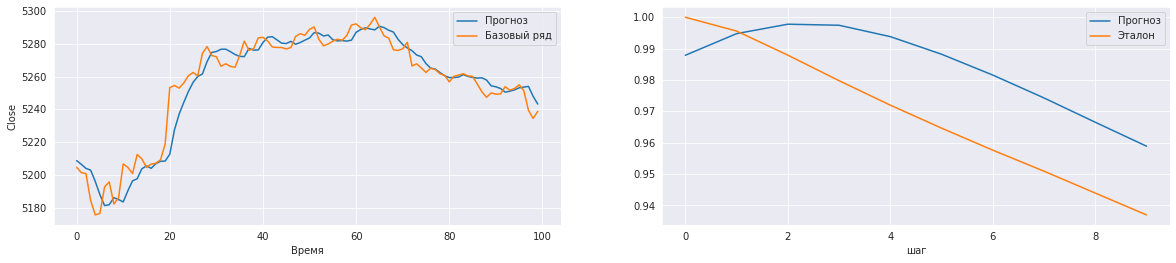


4. - Обратные величины  1/(x+1e-3): TrainTest.shape: (7591, 10) (7591, 1) (798, 10) (798, 1)


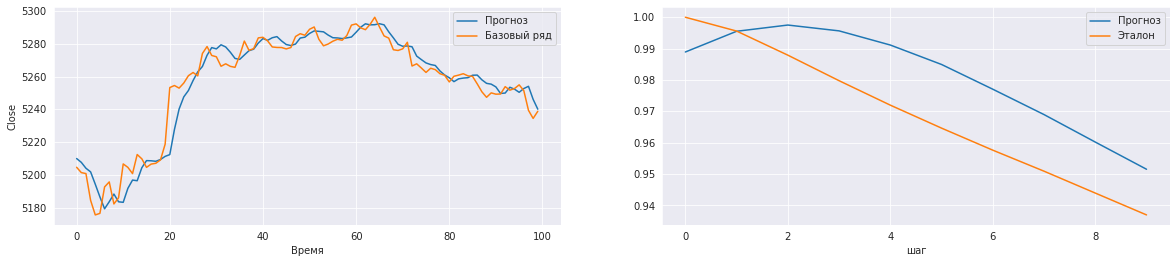


5. - Первые производные каналов: TrainTest.shape: (7590, 10) (7590, 1) (798, 10) (798, 1)


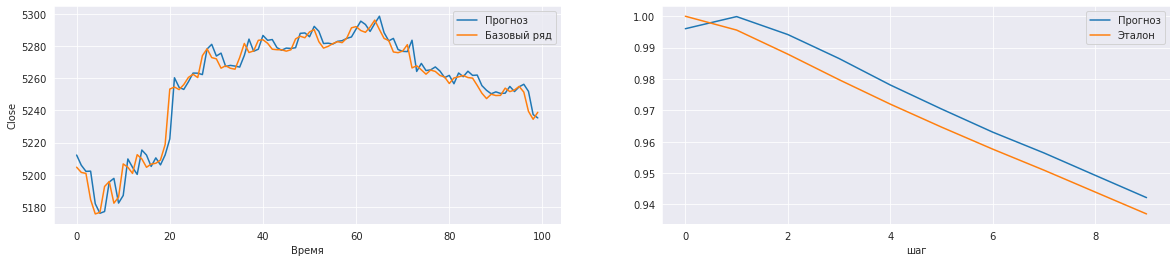


6. - Вторые производные каналов: TrainTest.shape: (7589, 10) (7589, 1) (798, 10) (798, 1)


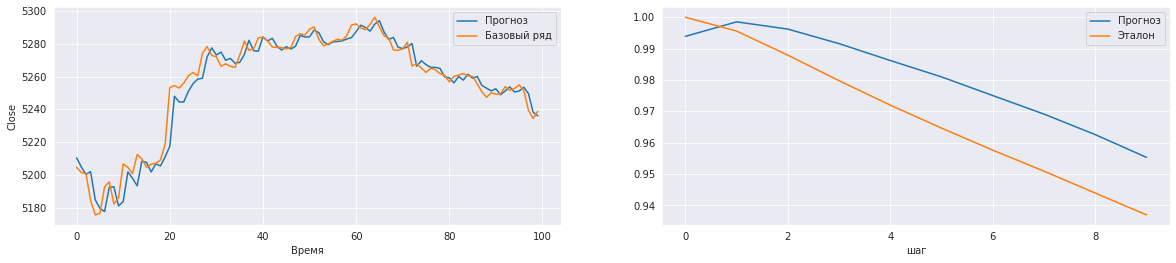

In [ ]:
data10 = datamean10(data)
for exp_step in ('I','II','III'):       # 3 варианта шага
  nrate=1                       # множитель sampling_rate, stride 
  valLen = 9000                 # начало тестовой
  dfb = data.copy()             # восстанавливаем исх. данные 

  if exp_step == 'II':             
    nrate=10                    # через 10  точек

  msg = exp_step +'.\t100 точек с шагом назад по ' + str(nrate)
  if exp_step == 'III':
    dfb = data10.copy()           # cpeднeeе
    valLen //= 10
    msg += ', cреднее по 10-ти точкам' 

  print(msg)

  for experience in range(6):  # 6 вариантов данных.
    dn = prepareDataSet(dfb,experience)
    trainLen = dn.shape[0]-valLen           # Размер тренировочной выборки
    xTrain, xTest = dn[:trainLen], dn[trainLen+xLen+2:]  # Работа с полученным мвассивом Dn
    xScaler = MinMaxScaler()
    xScaler.fit(xTrain)
    xTrain = xScaler.transform(xTrain)
    xTest = xScaler.transform(xTest)         # Масштабирование
    yTrain, yTest = np.reshape(dn[:trainLen,3],(-1,1)), np.reshape(dn[trainLen+xLen+2:,3],(-1,1)) 
    yScaler = MinMaxScaler()
    yScaler.fit(yTrain)
    yTrain = yScaler.transform(yTrain)
    yTest = yScaler.transform(yTest)
    print("TrainTest.shape:", xTrain.shape, yTrain.shape, xTest.shape, yTest.shape )
    # train генератор 
    trainDataGen = TimeseriesGenerator(xTrain, yTrain, length=xLen * nrate, sampling_rate=nrate,
                                      stride=nrate, batch_size=20)                
    # генератор для валидации
    testDataGen = TimeseriesGenerator(xTest, yTest, length=xLen * nrate, sampling_rate=nrate,   
                                      stride=nrate, batch_size=20)
    # генератор для предикт
    DataGen = TimeseriesGenerator(xTest, yTest, length=xLen * nrate, sampling_rate=nrate, 
                                      stride=nrate, batch_size=len(xTest))
    xVal=[]
    yVal=[]
    for i in DataGen:
      xVal.append(i[0])
      yVal.append(i[1])  

    xVal = np.array(xVal)
    yVal = np.array(yVal)  

    modelD = Sequential()
    modelD.add(Dense(300, input_shape = (xLen,xTrain.shape[1]), activation='linear'))
    modelD.add(Flatten())
    modelD.add(Dense(1,activation='linear'))

    modelD.compile(loss="mse", optimizer=Adam(lr=1e-4,clipnorm=1))

    def scheduler(epoch, lr):
      if epoch > 1 and epoch % 25 == 0:
        lr /= 10
      return lr 

    callback = LearningRateScheduler(scheduler)
    history = modelD.fit(trainDataGen, epochs = 60, validation_data = testDataGen,
                        callbacks=[callback], verbose=0)

    # График предсказания
    (predVal, yValUnscaled) = getPred(modelD, xVal[0], yVal[0], yScaler) #Прогнозируем данные
    showPredict(50, 100, 0, predVal, yValUnscaled)

Выводы:
1. Как и ожидалость разностные (дифференциальные) каналы дают улучшение.
2. Неожиданно - произведения и обратные величины дали улучшение корреляции.
3. Шаг в 10 точек - неудачный вариант.
4. Средние  - дают улучшение корреляции, но ведь ряд сглажен...